<a href="https://colab.research.google.com/github/Albmargar1/ClickbaitDetector/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!git clone https://github.com/Albmargar1/ClickbaitDetector

fatal: destination path 'ClickbaitDetector' already exists and is not an empty directory.


In [12]:
import pandas as pd
from collections import Counter
import math
import matplotlib.pyplot as plt
import numpy as np

In [13]:
class bcolors:
    blue = '\033[34m'
    end = '\033[0m'
    bold = '\033[1m'

In [14]:
input_data = pd.read_csv('/content/ClickbaitDetector/data/webis_train.csv')
print(input_data.columns)

Index(['Unnamed: 0', 'postMedia', 'postText', 'id', 'targetCaptions',
       'targetParagraphs', 'targetTitle', 'postTimestamp', 'targetKeywords',
       'targetDescription', 'truthJudgments', 'truthMean', 'truthClass',
       'truthMedian', 'truthMode'],
      dtype='object')


Para este problema sólo voy a usar información referente a las columnas 'postText' y 'truthClass'. El resto de las columnas quedan descartadas por aportar información irrelevante o redundante a este problema. Dichas columnas incluyen información:

*   Identificativa o temporal del tweet.
*   Referente al artículo al que el tweet enlaza.
*   Relativa al sistema de etiquetado del tweet como clickbait. 



In [15]:
train_df = input_data[['postText','truthClass']]

In [16]:
train_df.info()
print(bcolors.blue, 
      '\n\nValores nulos en postText:', 
      train_df['postText'].isna().sum(), 
      '\nValores nulos en truthClass:', 
      train_df['truthClass'].isna().sum(), 
      bcolors.end)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19538 entries, 0 to 19537
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   postText    19484 non-null  object
 1   truthClass  19538 non-null  object
dtypes: object(2)
memory usage: 305.4+ KB
 

Valores nulos en postText: 54 
Valores nulos en truthClass: 0 


Desechando las filas que incluyen valores nulos:

In [17]:
train_df = train_df.dropna().reset_index(drop=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19484 entries, 0 to 19483
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   postText    19484 non-null  object
 1   truthClass  19484 non-null  object
dtypes: object(2)
memory usage: 304.6+ KB


In [18]:
legit_tweets = train_df[train_df['truthClass'] == 'no-clickbait']
clickbait_tweets = train_df[train_df['truthClass'] == 'clickbait']

legit_count = legit_tweets.shape[0]
clickbait_count = clickbait_tweets.shape[0]
bad_labeled_count = train_df.shape[0] - (legit_count + clickbait_count)
clickbait_proportion = clickbait_count/(clickbait_count + legit_count+bad_labeled_count)

print(bcolors.blue,
      '\nTweets legítimos:', legit_count, 
      '\nTweets clickbait:', clickbait_count, 
      '\nTweets mal etiquetados:', bad_labeled_count,
      '\nProporción tweets clickbait:', clickbait_proportion, 
      bcolors.end)

 
Tweets legítimos: 14768 
Tweets clickbait: 4716 
Tweets mal etiquetados: 0 
Proporción tweets clickbait: 0.24204475467049888 


A continuación se realiza un estudio preliminar de qué tan probable es una palabra de aparecer en un tweet legítimo o clickbait, teniendo exclusivamente en cuenta la frecuencia de aparición en cada categoría. Se ha creado una máscara para limitar las palabras que se muestran, y que éstas sean frecuentes y dominantes en alguna de las dos categorías. 

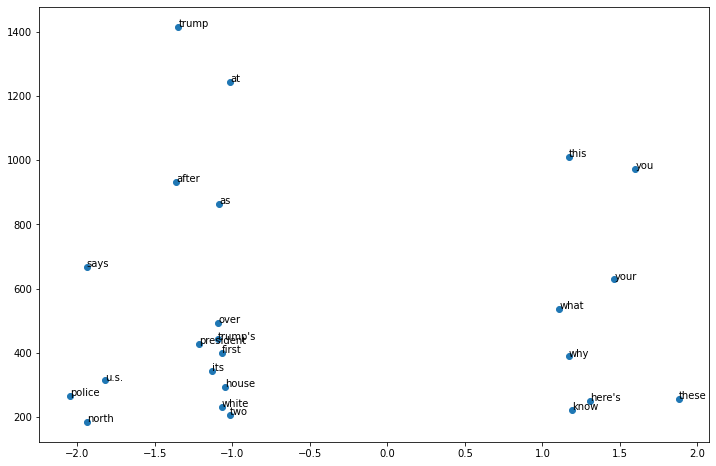

In [47]:
def build_frequency(dataframe, column_label):
  counter = Counter()
  dataframe[column_label].str.lower().str.split().apply(counter.update)
  return counter

def build_probabilities(counter, vocab):
  counter_all_words_freq = sum(counter.values())
  vocab_length = len(vocab)
  prob = {k: (counter.get(k, 0) + 1) / (counter_all_words_freq + vocab_length) for k in vocab.keys()}

  return prob

vocab_freq = build_frequency(train_df, 'postText')
legit_freq = build_frequency(legit_tweets, 'postText')
clickbait_freq = build_frequency(clickbait_tweets, 'postText')
  
legit_word_prob = build_probabilities(legit_freq, vocab_freq)
clickbait_word_prob = build_probabilities(clickbait_freq, vocab_freq)

loglikelihood = {k: math.log(clickbait_word_prob.get(k) / legit_word_prob.get(k)) for k in vocab_freq.keys()}
keys_list = [k for k in vocab_freq.keys()]
word_loglikelihood_array = np.array([v for v in loglikelihood.values()])
word_count_array = np.array([v for v in vocab_freq.values()])

mask = (word_count_array > 180) & (abs(word_loglikelihood_array) > 1.0)
mask_keys = {i: keys_list[i] for i in range(mask.shape[0]) if mask[i] == True}

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(word_loglikelihood_array[mask], word_count_array[mask])
for k,v in mask_keys.items():
  ax.annotate(v, (word_loglikelihood_array[k], word_count_array[k]))

#ax.arrow(0, 1300, 0, 1, head_width = 0.2, head_length = 0.2, width = 0.05, head_starts_at_zero = True)

Estos resultados no resultan muy reveladores, pero dan pequeñas pistas de qué se puede considerar legítimo y qué puede considerarse clickbait.

Por ejemplo, entre las palabras que más aparecen en los tweets que son clickbaits aparecen apelativos al lector ('you'/'your'), preguntas ('what'/'why') y adjetivos demostrativos ('this'/'these'). 

En el caso de tweets legítimos, parece que tiende a poseer palabras menos ambiguas, tales como 'u.s.'/'police'/'trump'/'president'.

Igualmente hay clasificaciones extrañas. Por ejemplo, 'says' está catalogada como una palabra que se usa mucho en tweets legítimos, cuando es una palabra que puede llevar a un clickbait.

In [63]:
logprior = math.log(len(clickbait_tweets)) - math.log(len(legit_tweets))
predicted_class = []
for tweet in train_df['postText']:
  p = logprior
  tweet_list = tweet.lower().split()
  for word in tweet_list:
    p += loglikelihood[word]
  if p > 0:
    predicted_class.append('clickbait')
  else:
    predicted_class.append('no-clickbait')

def build_metrics(predicted_label, true_label):
  TP = 0
  FP = 0
  TN = 0 
  FN = 0
  for p, y in zip(predicted_label, true_label):
    if p == 'clickbait' and y == 'clickbait':
      TP += 1
    elif p == 'clickbait' and y == 'no-clickbait':
      FP += 1
    elif p == 'no-clickbait' and y == 'clickbait':
      FN += 1
    elif p == 'no-clickbait' and y == 'no-clickbait':
      TN += 1

  metrics = {}
  metrics['accuracy'] = (TP + TN) / (TP + TN + FP + FN)
  metrics['precision'] = TP / (TP + FP)
  metrics['recall'] = TP / (TP + FN)
  metrics['specificity'] = TN / (TN + FP)
  metrics['F1'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'])

  return metrics

metrics = build_metrics(predicted_class, list(train_df['truthClass']))

print('accuracy =', metrics['accuracy'],
      '\nprecision =', metrics['precision'],
      '\nrecall =', metrics['recall'],
      '\nspecifity =', metrics['specificity'],
      '\nF1 =', metrics['F1'])

accuracy = 0.9023814411825087 
precision = 0.8272093023255814 
recall = 0.7542408821034775 
specifity = 0.9496885157096425 
F1 = 0.7890417036379769


El modelo de Naive Bayes posee un valor de F1-score de 0.789 a la hora de predecir si un tweet es clickbait. Este modelo estima mejor si un tweet es legítimo, dado su specifity de 0.950, ofreciendo por ello un accuracy global de 0.902. 

Este modelo es a lo mínimo que podemos aspirar, y sirve de comparativa respecto a los modelos Transformers.